In [2]:
from timeit import default_timer as timer
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from math import ceil, floor,  pi, sqrt
import scipy.ndimage

ModuleNotFoundError: No module named 'cv2'

In [ ]:
def sse(a, b):
    dist = ((a[:, 0] - b[:, 0]) ** 2) + ((a[:, 1] - b[:, 1]) ** 2)
    return np.sum(dist)

In [ ]:
point3d = np.loadtxt('3Dpoints.txt')
point2d = np.loadtxt('2Dpoints.txt')

A = []
for r in range(len(point3d)):
    xw = point3d[r][0]
    yw = point3d[r][1]
    zw = point3d[r][2]
    xi = point2d[r][0]
    yi = point2d[r][1]
    A.append([xw, yw, zw, 1, 0, 0, 0, 0, -xw*xi, -yw*xi, -zw*xi, -xi])
    A.append([0, 0, 0, 0, xw, yw, zw, 1, -xw*yi, -yw*yi, -zw*yi, -yi])
A = np.array(A)
# eigh is sorted ascending
eig_val, eig_vect = np.linalg.eigh(A.T @ A)
p = eig_vect[:, 0].reshape((3, 4))

# 2.
# convert the 3d points to homog by adding a col of ones
Xw = np.hstack((point3d, np.ones((point3d.shape[0], 1)))).T
# use p to transform points and then make it inhomogenous
P = p @  Xw
P = (P / P[2, :])[:2].T
print(f'Camera calibration SSE: {sse(P, point2d)}')

Camera calibration SSE: 18.673167936450383


The SSE was surprisingly low, I did not expect the algorithm to give such good results with the estimation. 

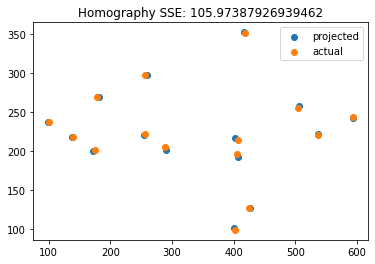

In [ ]:
raw = np.loadtxt('homography.txt', delimiter=',')
im1 = raw[:, :2]
im2 = raw[:, 2:]

x1 = im1[:, 0]
y1 = im1[:, 1]
x2 = im2[:, 0]
y2 = im2[:, 1]
x1_bar = np.average(x1)
y1_bar = np.average(y1)
x2_bar = np.average(x2)
y2_bar = np.average(y2)

s1 = sqrt(2) / (1/len(im1) *
                np.sum(np.sqrt((x1-x1_bar) ** 2 + (y1 - y1_bar) ** 2)))
s2 = sqrt(2) / (1/len(im2) *
                np.sum(np.sqrt((x2-x2_bar) ** 2 + (y2 - y2_bar) ** 2)))

t1 = np.array([[s1, 0, -s1*x1_bar],
               [0, s1, -s1*y1_bar],
               [0, 0, 1]])
t2 = np.array([[s2, 0, -s2*x2_bar],
               [0, s2, -s2*y2_bar],
               [0, 0, 1]])
# convert the points to homog by adding a col of ones
im1_h = np.hstack((im1, np.ones((im1.shape[0], 1)))).T
im2_h = np.hstack((im2, np.ones((im2.shape[0], 1)))).T

# normalize original images
im1_h = (t1 @ im1_h).T
im2_h = (t2 @ im2_h).T

A = []
for r in range(len(raw)):
    x = im1_h[r][0]
    y = im1_h[r][1]
    xp = im2_h[r][0]
    yp = im2_h[r][1]
    A.append([x, y, 1, 0, 0, 0, -x*xp, -y*xp, -xp])
    A.append([0, 0, 0, x, y, 1, -x*yp, -y*yp, -yp])
A = np.array(A)
# eigh is sorted ascending
eig_val, eig_vect = np.linalg.eigh(A.T @ A)
h_squiggle = eig_vect[:, 0].reshape((3, 3))
# reverse standardization
h = np.linalg.inv(t2) @ h_squiggle @ t1


# 4. calculate projected points for img2

# transform points and make inhomogenous
im1 = np.hstack((im1, np.ones((im1.shape[0], 1)))).T
p2 = h@(im1)
p2 = ((p2 / p2[2, :])[:2]).T
plt.gca().scatter(p2[:, 0], p2[:, 1], label='projected')
plt.gca().scatter(im2[:, 0], im2[:, 1], label='actual')
plt.gca().legend()

# 5.
plt.gca().set_title(f'Homography SSE: {sse(p2, im2)}')
plt.show()



The projected points were very similar to the actuals, so I was pretty surprised.